In [1]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from selenium.common.exceptions import NoSuchElementException
import time
import datetime as dt
import re
import numpy as np
import pandas as pd
from stock_scraper import get_stock_prices
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import axes3d
import os


from Markowitz import get_vol, opt_weight

%matplotlib inline

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--no-sandbox')

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768)) 
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1024x768x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1024x768x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [2]:
plt.rcParams['figure.figsize'] = (15,10)

In [3]:
from IPython.display import HTML

In [4]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [5]:
def convert_to_df(df_str):
    header = re.findall("[ , \w]+\\n", df_str)[1]
    columns = re.findall("[\w]+", header)
    number_cols = len(columns) + 1 # Including index as column
    
    n = len(columns)
    all_numbers = re.findall("[-,.,0-9]+", df_str)
    values = [float(all_numbers[i]) for i in range(len(all_numbers)) if i % number_cols != 0]
    vals_array = np.array(values).reshape((int(len(values) / n), n))
    
    tickers = re.findall('\[(.*)\]', df_str)
    
    result_df = pd.DataFrame(index=tickers, data=vals_array, columns=columns)
    
    return result_df

In [6]:
driver = webdriver.Chrome("{}/chromedriver".format(os.getcwd()), 
                          chrome_options=chrome_options,
                         service_args=['--verbose', '--log-path=/tmp/chromedriver.log'])

# Get to algorithm login page
driver.get("https://www.quantopian.com/live_algorithms/5ac7078347a9990019bd2395")

# Log in and proceed to live trading page
username = driver.find_element_by_id("user_email")
password = driver.find_element_by_id("user_password")
username.send_keys("cib.pairs@gmail.com")
password.send_keys("CIBPairs17")
password.send_keys(Keys.ENTER)
time.sleep(0.5)

# Go to the logs pane
driver.find_element_by_css_selector("i.fontello-icon.fontello-icon-book").click()
        
    
# Wait until logs are displayed
print("Waiting for logs...")
weights_showing = False
while not weights_showing:
    try:
        driver.find_element_by_css_selector("div.logs-footer.hidden")
    except NoSuchElementException:
        time.sleep(3)
        continue
        
    print("Done")
    weights_showing = True
    
    
# Extract weights and tickers
weights_msg = driver.find_elements_by_xpath("//*[@class='logmsg' and contains(text(), 'WEIGHTS:')]")
weights_txt = weights_msg[0].text

tickers = re.findall('\[(.*)\]', weights_txt)
weights = re.findall('[-,.,0-9]+\\n', weights_txt)
weights = [el.replace('\n', '') for el in weights]
weights = [float(weight) for weight in weights]
       
portfolio = pd.Series(index = tickers, data = weights)
print("\nAlgo picks:\n" + str(portfolio))

# Extract scores of stocks picked
scores_msg = driver.find_elements_by_xpath("//*[@class='logmsg' and contains(text(), 'FACTOR SCORES:')]")
scores_txt = scores_msg[0].text
scores_df = convert_to_df(scores_txt)

# Extract scores of bottom ranked stocks
bottom_scores_msg = driver.find_elements_by_xpath("//*[@class='logmsg' and contains(text(), 'BOTTOM SCORES:')]")
bottom_scores_txt = bottom_scores_msg[0].text
bottom_scores_df = convert_to_df(bottom_scores_txt)

# Extract scores of top ranked stocks
top_scores_msg = driver.find_elements_by_xpath("//*[@class='logmsg' and contains(text(), 'TOP SCORES:')]")
top_scores_txt = top_scores_msg[0].text
top_scores_df = convert_to_df(top_scores_txt)


print("\nPortfolio Scores:\n", scores_df)
print("\nBottom Scores:\n", bottom_scores_df)
print("\nTop Scores:\n", top_scores_df)

time.sleep(5)
driver.close()

Waiting for logs...
Done

Algo picks:
INNT   -0.423509
OMER   -0.298185
BLUE   -0.278306
T       0.292683
GOLD    0.340403
CNAT    0.366914
dtype: float64

Portfolio Scores:
       composite  momentum  sentiment   value
INNT    -0.4625   -1.0127    -0.1434  0.0000
OMER    -0.5352   -1.0075    -0.1320 -0.3969
BLUE    -0.3518    0.0000    -0.6818 -0.3956
T        0.3157    0.0000     0.1120  1.3545
GOLD     0.4230    1.0042     0.1145 -0.1224
CNAT     0.5460    1.2043     0.1969 -0.0721

Bottom Scores:
       composite  momentum  sentiment   value
INNT    -0.4625   -1.0127    -0.1434  0.0000
OMER    -0.5352   -1.0075    -0.1320 -0.3969
BLUE    -0.3518    0.0000    -0.6818 -0.3956
TWTR    -0.1800    0.0000    -0.1974 -0.5053
GS      -0.2356    0.0000    -0.5260 -0.1257
TEUM    -0.2668    0.0000    -0.1524 -1.0294
BTG     -0.1880    0.0000    -0.4086 -0.1226
GERN    -0.1465    0.0000    -0.1671 -0.3981
SRNE    -0.1532    0.0000    -0.1560 -0.4542
SQ      -0.0531    0.0000    -0.1328  0.000

# Analysis of Portfolio Picks

Raw Portfolio Picks


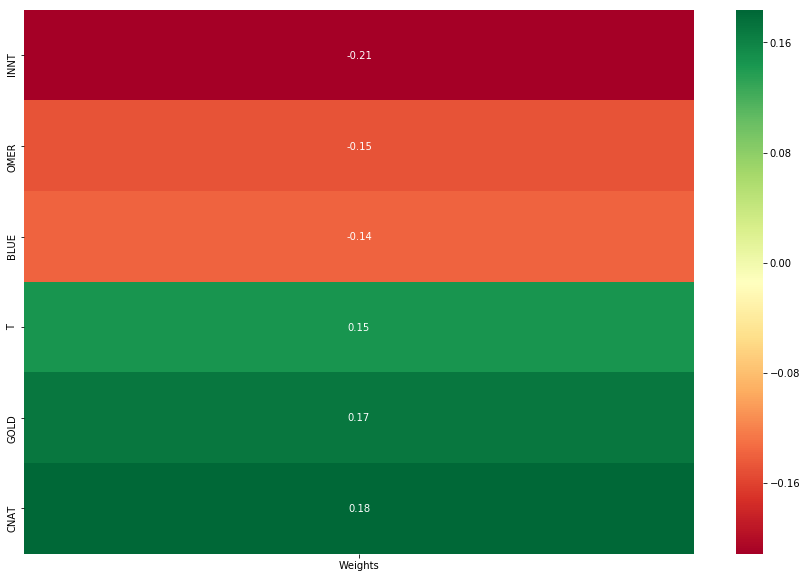

In [7]:
print("Raw Portfolio Picks")
sns.heatmap(pd.DataFrame(portfolio/2, columns=['Weights']), annot=True, cmap='RdYlGn')

Portfolio Factor Analysis


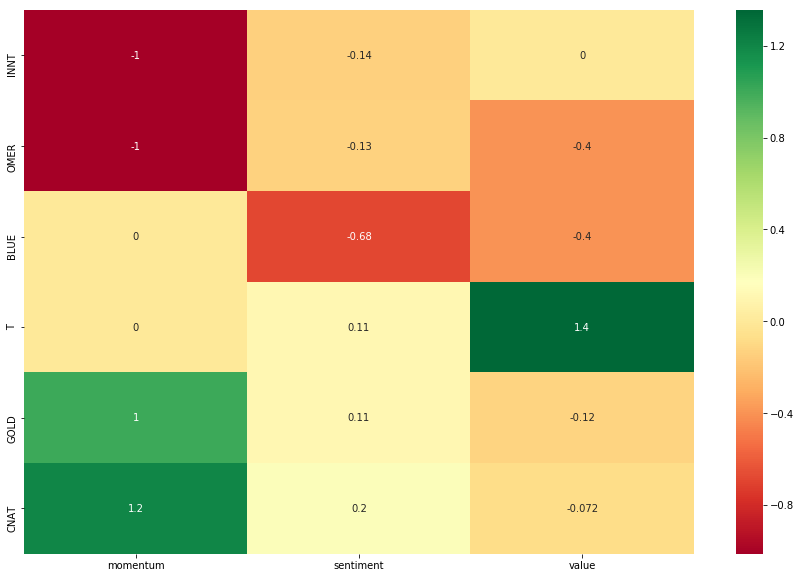

In [8]:
print("Portfolio Factor Analysis")
sns.heatmap(scores_df.drop(['composite'], axis=1), annot=True, cmap='RdYlGn')

In [9]:
COVAR_LOOKBACK = 90 # In days, not just business days
today = dt.date.today()
start = dt.date.today() - dt.timedelta(COVAR_LOOKBACK)
prices = get_stock_prices(portfolio.index, str(start), str(today))['Adj Close']

Succeeded in 2.18s after 2 attempts


In [10]:
try:
    null_locs = np.where(prices == 'null')
    for i in range(len(null_locs[0])):
        prices.iloc[null_locs[0][i], null_locs[1][i]] = np.nan
except:
    pass
prices = prices.fillna(method='pad')
prices = prices.apply(pd.to_numeric)
prices = prices.dropna(thresh=int(len(prices)*0.75), axis=1)

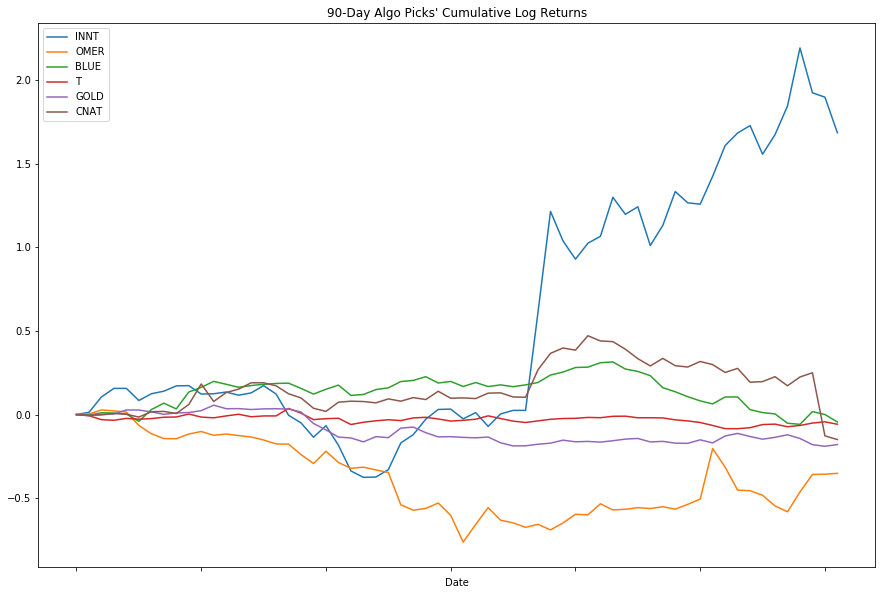

In [11]:
rets = prices.pct_change()

A = rets.dropna().T
A -= np.mean(A, axis=0)

cum_returns = (1 + rets.fillna(0)).cumprod()
np.log(cum_returns).plot(title='%d-Day Algo Picks\' Cumulative Log Returns' % COVAR_LOOKBACK)


In [12]:
A

Date,2018-01-09,2018-01-10,2018-01-11,2018-01-12,2018-01-16,2018-01-17,2018-01-18,2018-01-19,2018-01-22,2018-01-23,...,2018-03-23,2018-03-26,2018-03-27,2018-03-28,2018-03-29,2018-04-02,2018-04-03,2018-04-04,2018-04-05,2018-04-06
INNT,0.014340,0.075725,0.044029,-0.003270,-0.034476,0.026024,0.011866,0.033129,-0.033714,-0.068967,...,0.182574,0.079745,0.065623,-0.124874,0.108152,0.179321,0.319643,-0.228539,0.034057,-0.149356
OMER,0.004322,0.003836,-0.014147,-0.009859,-0.042027,-0.063314,-0.032096,-0.000271,-0.006614,-0.004653,...,-0.124791,-0.126688,0.017157,0.005605,-0.078416,-0.041697,0.030301,0.117401,0.061137,0.047886
BLUE,-0.002832,-0.005974,-0.010348,-0.008805,-0.007534,0.057655,0.035463,-0.032847,0.070924,0.008726,...,0.023077,0.001507,-0.052356,0.015157,-0.024416,-0.061850,-0.102244,0.085954,0.042612,-0.001080
T,-0.006192,-0.043635,-0.012426,0.008243,0.030646,-0.011655,0.004517,0.002541,-0.017619,-0.037743,...,-0.038337,0.001484,0.026468,0.051477,-0.013753,-0.023105,-0.088050,0.021532,0.066901,0.028593
GOLD,-0.006060,-0.011670,-0.007071,0.021207,0.034926,-0.026052,-0.018227,0.009101,-0.032822,-0.008361,...,0.022831,0.017263,0.002109,0.016548,-0.005108,0.007820,-0.117864,-0.029059,0.050115,0.053096
CNAT,-0.003578,-0.018282,-0.000038,-0.007516,0.018466,0.017343,-0.001523,-0.011653,0.019845,0.110998,...,-0.065353,0.026689,-0.059002,0.036087,0.013541,-0.060488,-0.041785,0.032710,-0.254822,0.020860


In [13]:
from sklearn.decomposition import PCA
def visualize_PCA(data, num_components=3, title='pca'):
    samples = data
    pca = PCA(n_components=num_components, svd_solver='full')
    x_new = pca.fit_transform(samples)
    if num_components == 2:
        x_new = np.array([x_new[:, 0], x_new[:, 1]])
        plt.scatter(x_new[0], x_new[1])
        plt.title(title)
        for i in range(len(data.index)):
            plt.annotate(data.index[i], xy=(x_new[0, i],x_new[1, i]), xytext=(15,0), textcoords='offset points')
        plt.show()
    elif num_components == 3:
        x_new = np.array([x_new[:, 0], x_new[:, 1], x_new[:, 2]])
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x_new[0], x_new[1], x_new[2])
        for i in range(len(A)): #plot each point + it's index as text above
            ax.text(x_new[0,i],x_new[1,i],x_new[2,i],  A.index[i], size=10, zorder=1,  
            color='k') 
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')

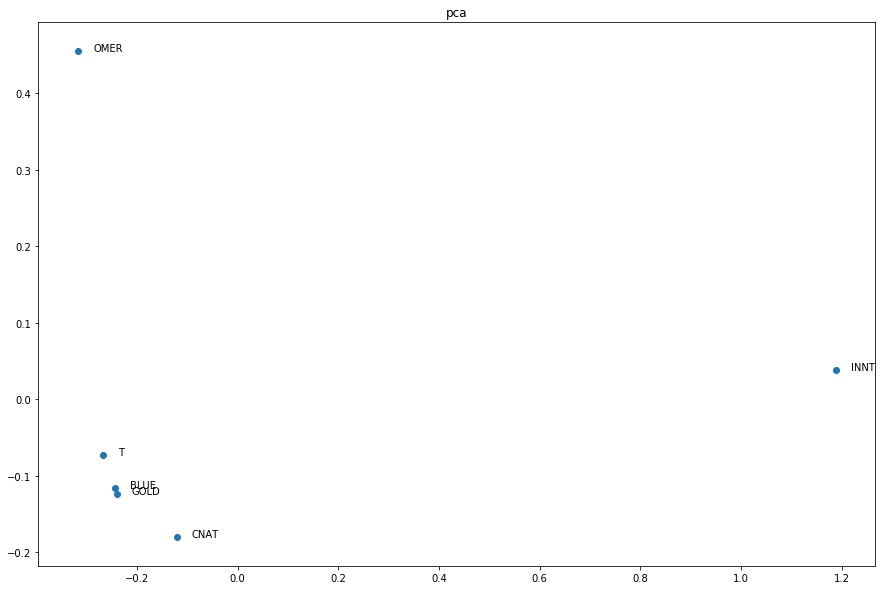

In [14]:
visualize_PCA(A, num_components=2)

3D PRINCIPLE COMPONENTS PROJECTION OF PAST 90 DAY RETURNS


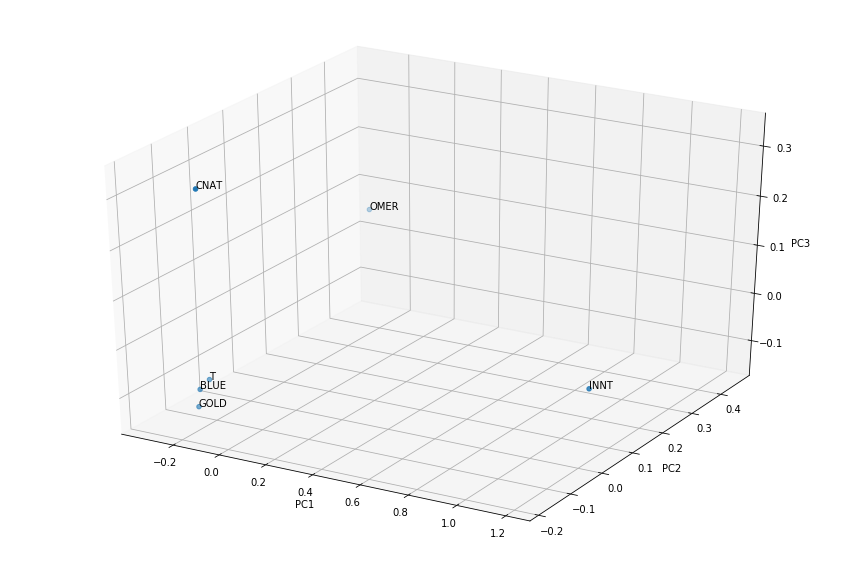

In [15]:
# Now let's project on 3 dimensions
visualize_PCA(A)

print("3D PRINCIPLE COMPONENTS PROJECTION OF PAST %d DAY RETURNS" % COVAR_LOOKBACK)

In [16]:
from sklearn.manifold import TSNE
def visualize_TSNE(data, title='tsne'):
    samples = data
    tsne = TSNE(n_components=2)
    x_new = tsne.fit_transform(samples)
    x_new = np.array([x_new[:, 0], x_new[:, 1]])
    plt.scatter(x_new[0], x_new[1])
    for i in range(len(data.index)):
            plt.annotate(data.index[i], xy=(x_new[0, i],x_new[1, i]), xytext=(15,0), textcoords='offset points')
    plt.title(title)
    plt.show()

2D TSNE of past 90 Day Returns


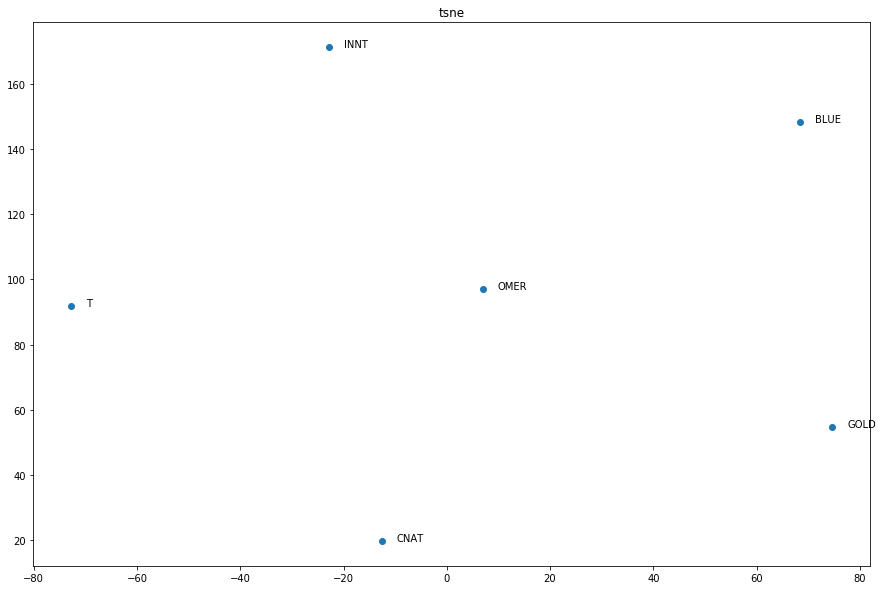

In [17]:
print('2D TSNE of past 90 Day Returns')
visualize_TSNE(A)

COVARIANCE MATRIX FROM PAST 90 DAYS RETURNS


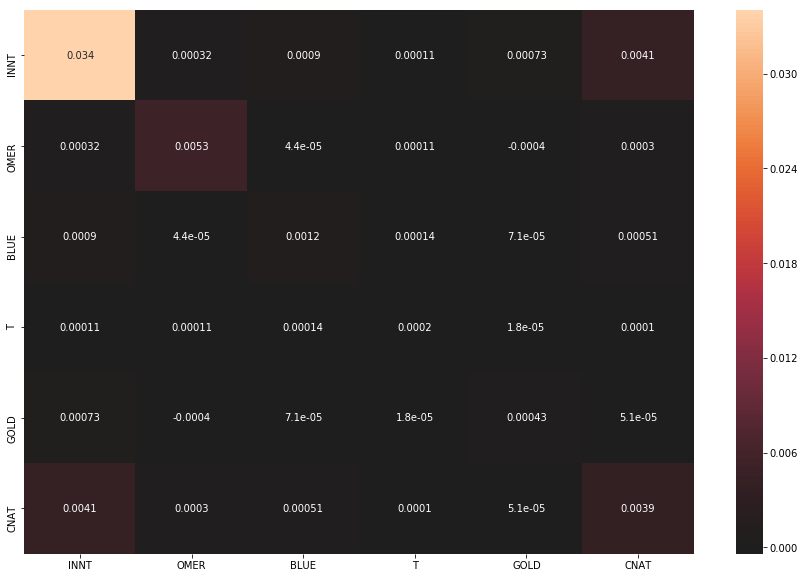

In [18]:
cov_mat = rets.dropna().cov()
print("COVARIANCE MATRIX FROM PAST %d DAYS RETURNS" % COVAR_LOOKBACK)
sns.heatmap(cov_mat, annot=True, center=0)

In [19]:
from sklearn.cluster import KMeans
def corr_matrix_data(X, num_clusters=3, x_labels = False):
    # demean the data
    X_demeaned = X - np.mean(X, 0) 
    
    _, _, V = np.linalg.svd(X_demeaned)
    V = V.T
    
    # get projected data
    X_proj = X_demeaned @ V[:, :num_clusters]
    
    # do some k-means clustering to identify which points are in which cluster
    km = KMeans(n_clusters = num_clusters)
    clusters = km.fit_predict(X_proj)
    
    # sort data based on identified clusters 
    t = X.copy()
    t['cluster'] = clusters
    t = t.sort_values("cluster")
    t = t.drop("cluster", 1)
    plt.imshow(t.T.corr(), "hot")
    plt.colorbar()
    plt.grid(False)
    plt.yticks(range(len(X)), t.index)
    if x_labels:
        plt.xticks(range(len(X)), t.index)
    

Unclustered Correlation Matrix Heat Map


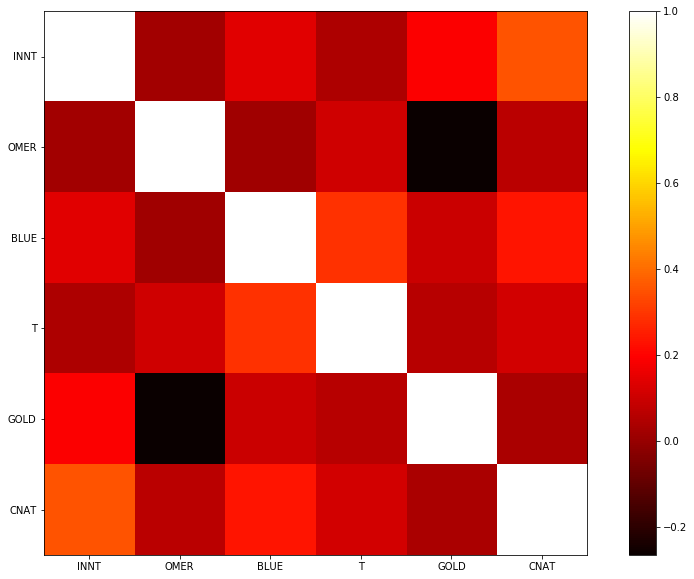

In [20]:
print("Unclustered Correlation Matrix Heat Map")
plt.imshow(rets.dropna().corr(), "hot")
plt.colorbar()
plt.grid(False)
_ = plt.xticks(range(rets.shape[1]), rets.columns)
_ = plt.yticks(range(rets.shape[1]), rets.columns)

2-Clustered Correlation Matrix Heat Map


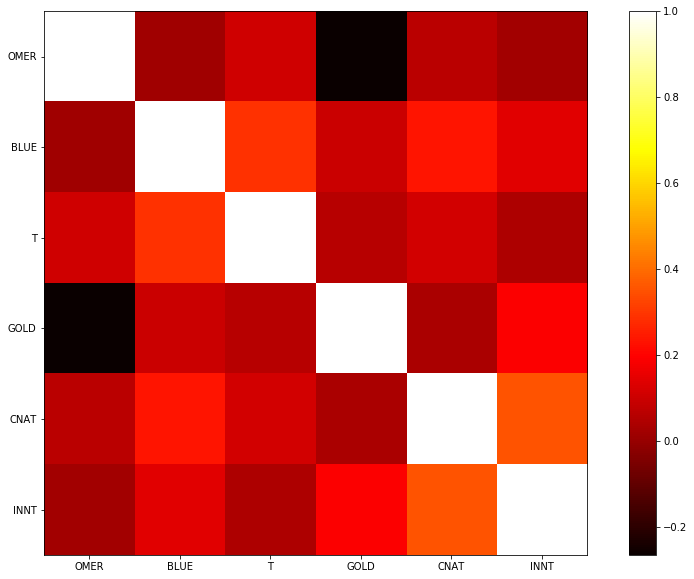

In [21]:
NUM_CLUSTERS = 2
print("%d-Clustered Correlation Matrix Heat Map" % NUM_CLUSTERS)
corr_matrix_data(rets.dropna().T, num_clusters=NUM_CLUSTERS, x_labels=True)

In [22]:
return_sd = pd.DataFrame(index = A.index)
return_sd['E[r]'] = scores_df.loc[A.index, 'composite']
return_sd['vol'] = [np.sqrt(cov_mat.iloc[i, i]) for i in range(len(cov_mat))]

In [23]:
def get_MVP(mu_vec, cov_mat, mark_vols, mark_rets, stocks):
    MVP_index = np.argmin(mark_vols)
    MVP = opt_weight(mark_rets[MVP_index], cov_mat, mu_vec)
    MVP_series = pd.Series(index=stocks, data=MVP.reshape((len(MVP))))
    print("Minimum Variance Portfolio:\n" + str(MVP_series.sort_values()))
    
    return MVP_series

In [24]:
def get_market_port(mu_vec, cov_mat, mark_vols, mark_rets, rf, stocks):
    derivatives = []
    for i in range(1, len(mark_rets) - 1):
        derivative = (mark_rets[i + 1] - mark_rets[i - 1]) / (mark_vols[i + 1] - mark_vols[i - 1])
        derivatives.append(derivative)
        
    cap_mkts_slopes = []
    for i in range(1, len(mark_rets) - 1):
        cap_mkts_slope = (mark_rets[i] - rf) / mark_vols[i]
        cap_mkts_slopes.append(cap_mkts_slope)
        
    MVP_index = np.argmax(derivatives)
    market_portfolio_index = np.argmin((np.array(derivatives[MVP_index:]) - np.array(cap_mkts_slopes[MVP_index:]))**2)
    market_portfolio_index += MVP_index
    market_portfolio_ret = mark_rets[market_portfolio_index - 1]
    market_portfolio = opt_weight(market_portfolio_ret, cov_mat, mu_vec)
    market_port_series = pd.Series(index=stocks, data=market_portfolio.reshape((len(market_portfolio))))
    
    cap_mkt_slope = cap_mkts_slopes[market_portfolio_index]
    
    print("Market Portfolio, assuming risk-free rate of %.2f:\n" % rf + str(market_port_series.sort_values()))
    
    return market_port_series, cap_mkt_slope
    

In [25]:
RF_RATE = 0.03

def plot_eff_front(mu_vec, cov_mat, stocks):
    mu_vec = mu_vec.reshape((len(mu_vec), 1))
    rets = np.linspace(-2 * np.abs(min(mu_vec)), 2*np.abs(max(mu_vec)), 100)
    vols = [get_vol(opt_weight(r, cov_mat, mu_vec), cov_mat) for r in rets]
    
    MVP = get_MVP(mu_vec, cov_mat, vols, rets, stocks)
    market_port, cap_mkt_slope = get_market_port(mu_vec, cov_mat, vols, rets, RF_RATE, stocks)
    x = np.linspace(0, max(vols), 100)
    cap_mkts_line = [RF_RATE + cap_mkt_slope*x for x in x]
    
    plt.plot(vols, rets)
    plt.plot(x, cap_mkts_line)
    plt.xlim(xmin=0)
    
    return MVP, market_port

In [26]:
print("Using scores as expected returns, Return-Volatility Table:\n", return_sd)

Using scores as expected returns, Return-Volatility Table:
         E[r]       vol
INNT -0.4625  0.184454
OMER -0.5352  0.073077
BLUE -0.3518  0.034393
T     0.3157  0.014135
GOLD  0.4230  0.020680
CNAT  0.5460  0.062630


Minimum Variance Portfolio:
INNT   -0.008465
BLUE    0.008915
CNAT    0.020065
OMER    0.034506
GOLD    0.334744
T       0.610236
dtype: float64
Market Portfolio, assuming risk-free rate of 0.03:
BLUE   -0.255533
OMER   -0.025613
INNT   -0.020473
CNAT    0.088559
GOLD    0.421576
T       0.791483
dtype: float64


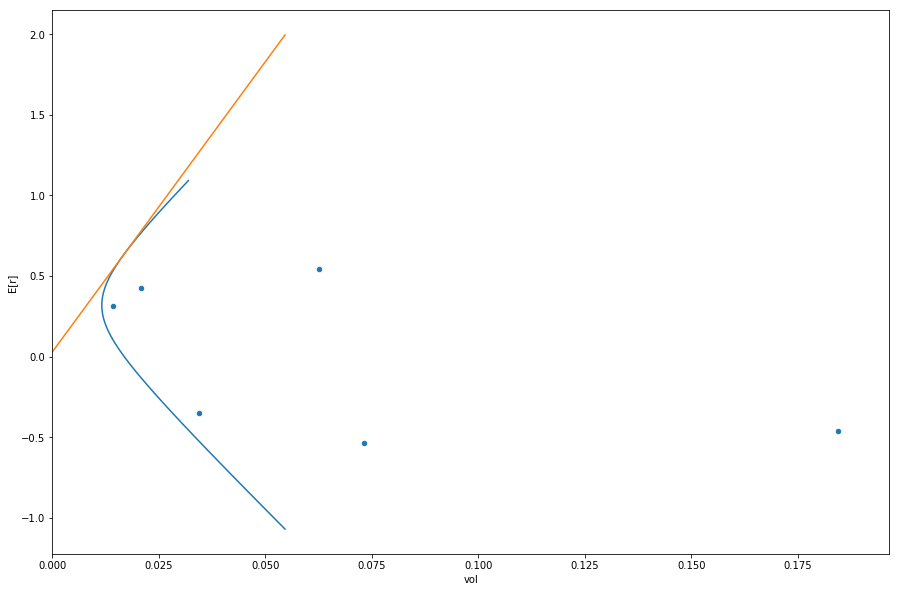

In [27]:
return_sd.plot.scatter(x='vol', y='E[r]')
MVP1, market_port1 = plot_eff_front(np.array(return_sd['E[r]']), np.array(cov_mat), return_sd.index)

In [28]:
def unlever_portfolio(portfolio):
    unlevered_port = portfolio.copy()
    short_sum = 0
    long_sum = 0
    for weight in unlevered_port:
        if weight < 0:
            short_sum -= weight
        else:
            long_sum += weight
            
    for i in range(len(unlevered_port)):
        if unlevered_port[i] < 0:
            unlevered_port[i] /= short_sum
        else:
            unlevered_port[i] /= long_sum

    if short_sum != 0:
        unlevered_port /= 2
            
    return unlevered_port

Unlevered Minimum Variance Portfolio


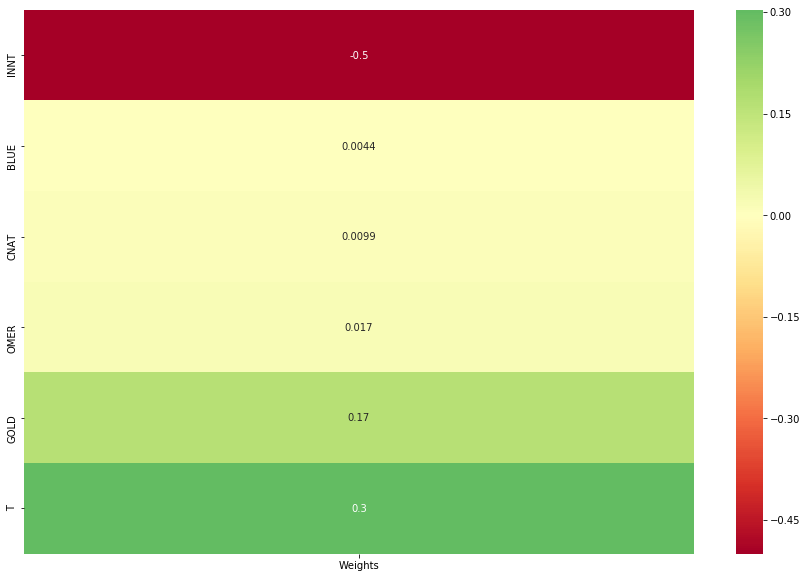

In [29]:
unlevered_MVP1 = unlever_portfolio(MVP1)
print("Unlevered Minimum Variance Portfolio")
sns.heatmap(pd.DataFrame(unlevered_MVP1, columns=['Weights']).sort_values('Weights'), annot=True, cmap='RdYlGn', center=0)

Unlevered Market Portfolio


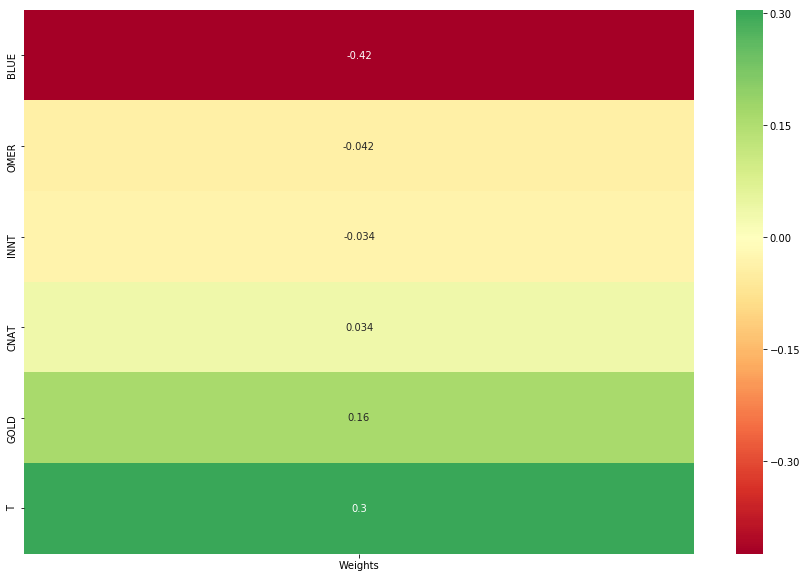

In [30]:
unlevered_market_port1 = unlever_portfolio(market_port1)
print("Unlevered Market Portfolio")
sns.heatmap(pd.DataFrame(unlevered_market_port1, columns=['Weights']).sort_values('Weights'), annot=True, cmap='RdYlGn', center=0)

# Analysis of Other Top and Bottom Stocks

In [31]:
all_scores = pd.concat([bottom_scores_df, top_scores_df], axis=0)

Factor Analysis


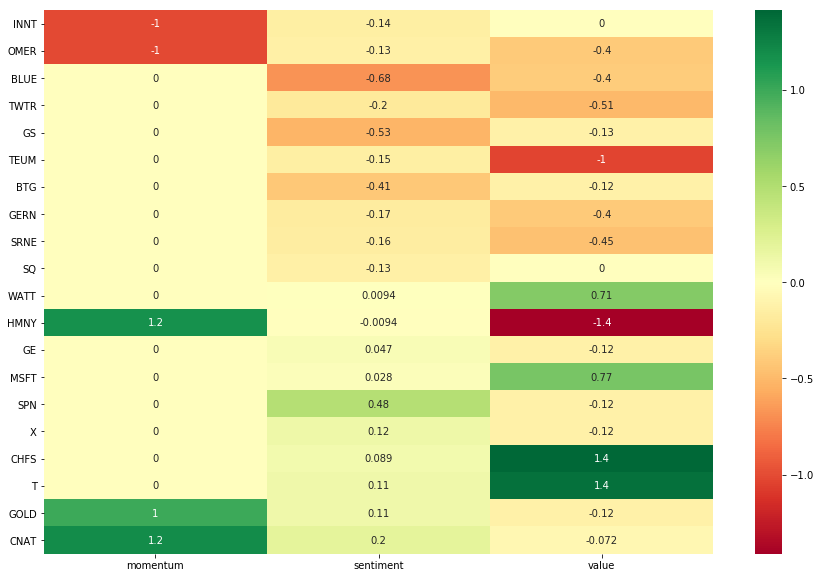

In [32]:
print("Factor Analysis")
sns.heatmap(all_scores.drop(['composite'], axis=1), annot=True, cmap='RdYlGn')

In [33]:
COVAR_LOOKBACK = 90 # In days, not just business days
today = dt.date.today()
start = dt.date.today() - dt.timedelta(COVAR_LOOKBACK)
prices = get_stock_prices(all_scores.index, str(start), str(today))['Adj Close']

Succeeded in 2.25s after 1 attempts


In [34]:
try:
    null_locs = np.where(prices == 'null')
    for i in range(len(null_locs[0])):
        prices.iloc[null_locs[0][i], null_locs[1][i]] = np.nan
except:
    pass
prices = prices.fillna(method='pad')
prices = prices.apply(pd.to_numeric)
prices = prices.dropna(thresh=int(len(prices)*0.75), axis=1)

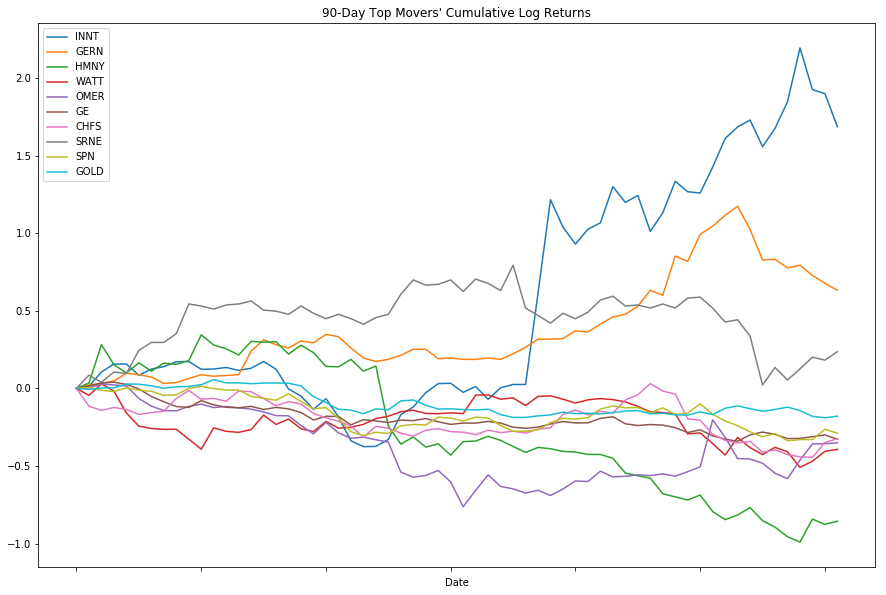

In [35]:
rets = prices.pct_change()

A = rets.dropna().T
A -= np.mean(A, axis=0)


cum_returns = (1 + rets.fillna(0)).cumprod()
top_movers = np.abs(cum_returns.iloc[-1] - 1).sort_values(ascending=False).head(10).index
np.log(cum_returns)[top_movers].plot(title='%d-Day Top Movers\' Cumulative Log Returns' % COVAR_LOOKBACK)


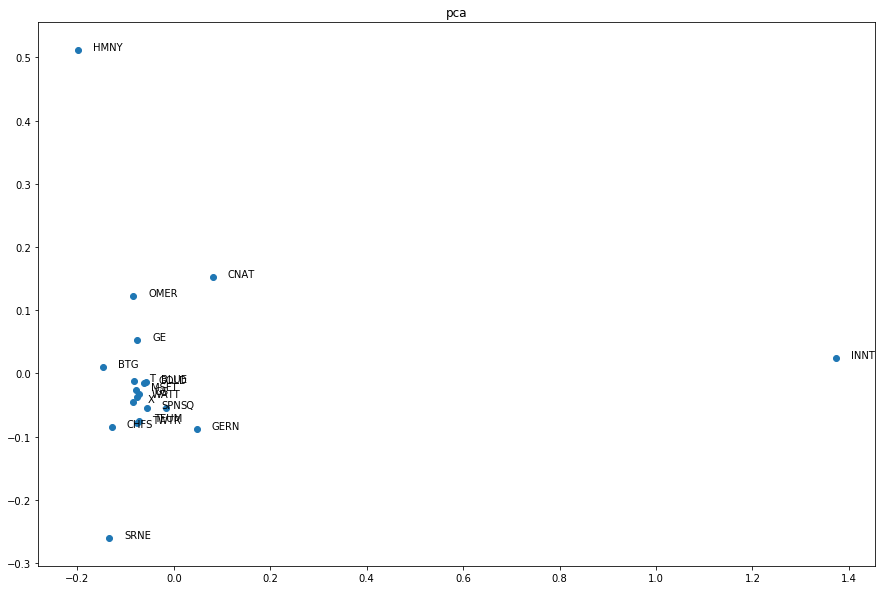

In [36]:
visualize_PCA(A, num_components=2)

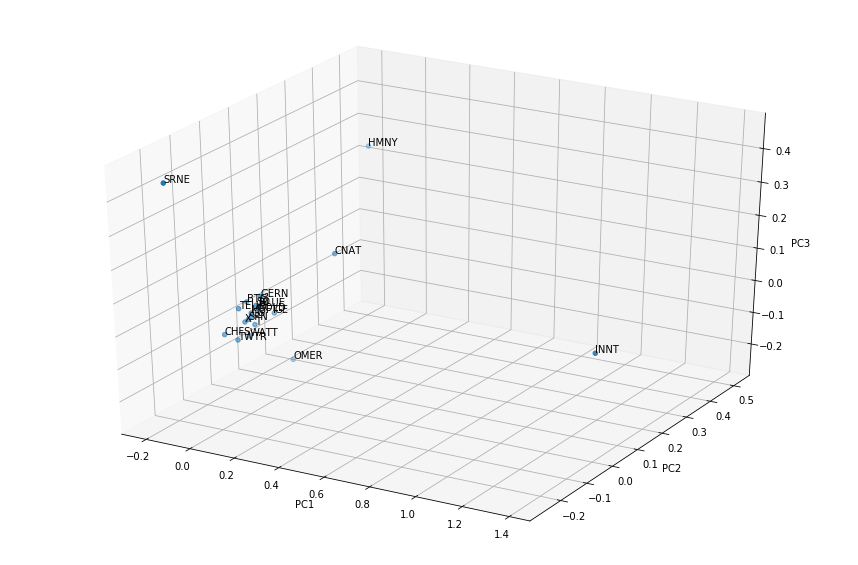

In [37]:
# Now let's project on 3 dimensions
visualize_PCA(A)

2D TSNE of past 90 Day Returns


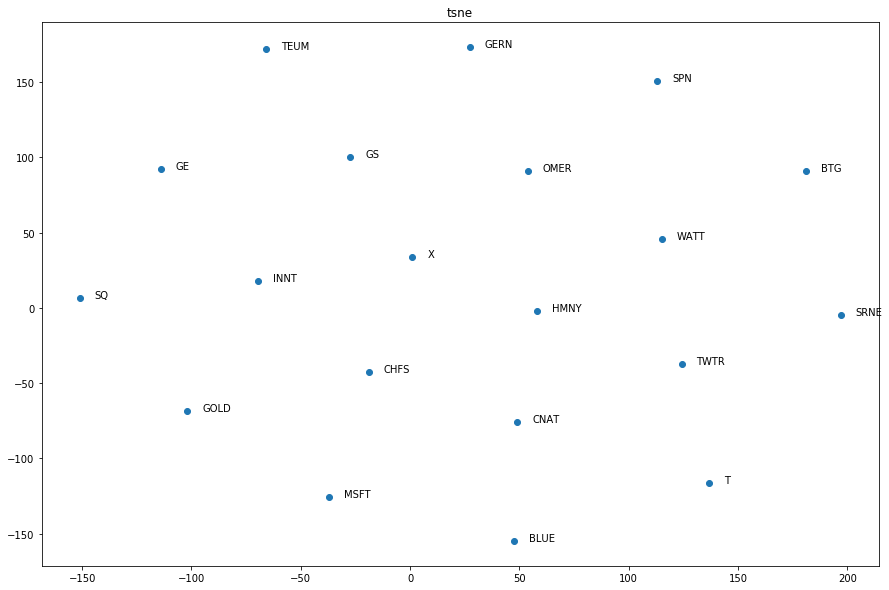

In [38]:
print('2D TSNE of past 90 Day Returns')
visualize_TSNE(A)

COVARIANCE MATRIX FROM PAST 90 DAYS RETURNS


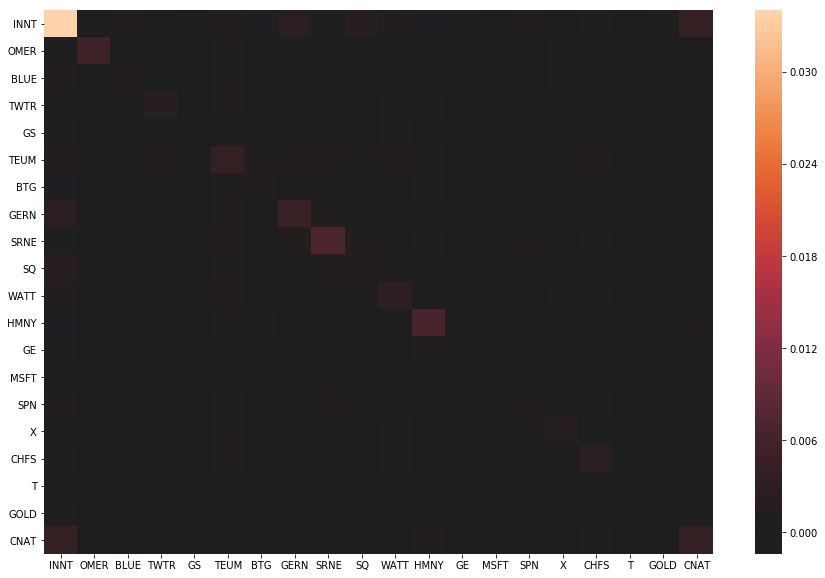

In [39]:
cov_mat = rets.dropna().cov()
print("COVARIANCE MATRIX FROM PAST %d DAYS RETURNS" % COVAR_LOOKBACK)
sns.heatmap(cov_mat, annot=False, center=0)

Unclustered Correlation Matrix Heat Map


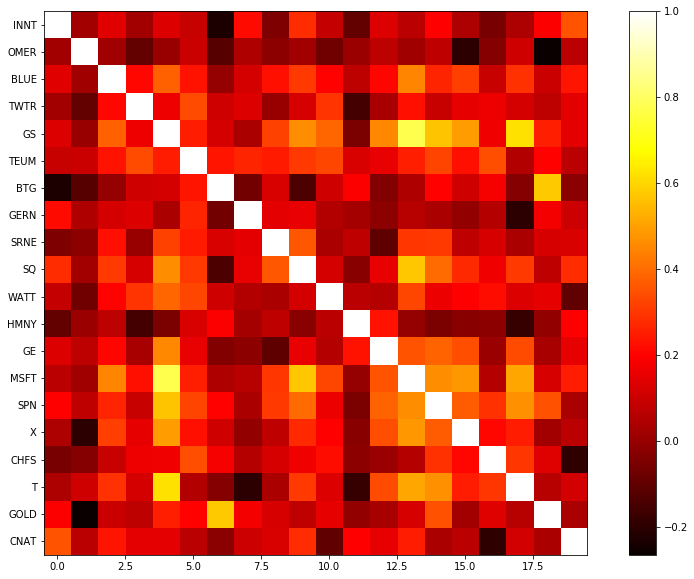

In [40]:
print("Unclustered Correlation Matrix Heat Map")
plt.imshow(rets.dropna().corr(), "hot")
plt.colorbar()
plt.grid(False)
_ = plt.yticks(range(rets.shape[1]), rets.columns)

3-Clustered Correlation Matrix Heat Map


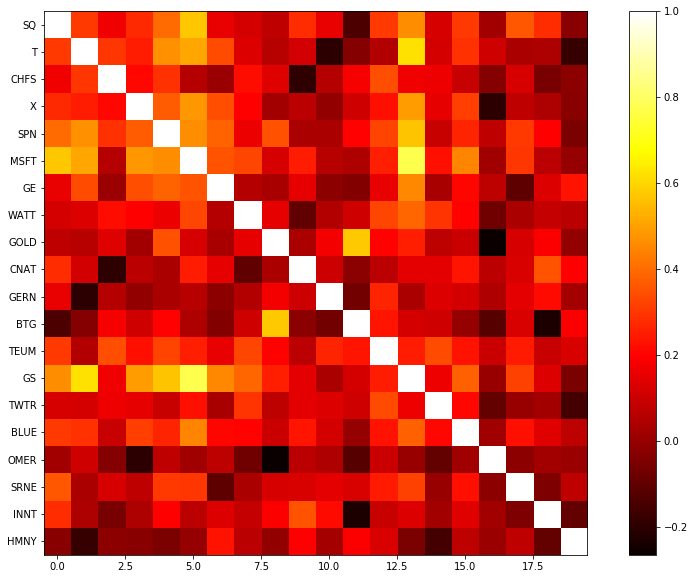

In [41]:
NUM_CLUSTERS = 3
print("%d-Clustered Correlation Matrix Heat Map" % NUM_CLUSTERS)
corr_matrix_data(rets.dropna().T, num_clusters=NUM_CLUSTERS)

In [42]:
return_sd = pd.DataFrame(index = A.index)
return_sd['E[r]'] = all_scores.loc[A.index, 'composite']
return_sd['vol'] = [np.sqrt(cov_mat.iloc[i, i]) for i in range(len(cov_mat))]

In [43]:
print("Using scores as expected returns, Return-Volatility Table:\n", return_sd)

Using scores as expected returns, Return-Volatility Table:
         E[r]       vol
INNT -0.4625  0.184454
OMER -0.5352  0.073077
BLUE -0.3518  0.034393
TWTR -0.1800  0.040590
GS   -0.2356  0.018860
TEUM -0.2668  0.061708
BTG  -0.1880  0.030024
GERN -0.1465  0.067950
SRNE -0.1532  0.081595
SQ   -0.0531  0.033775
WATT  0.1454  0.054794
HMNY  0.1784  0.081018
GE   -0.0056  0.022118
MSFT  0.1657  0.021232
SPN   0.1677  0.033110
X     0.0250  0.037949
CHFS  0.3186  0.047090
T     0.3157  0.014135
GOLD  0.4230  0.020680
CNAT  0.5460  0.062630


Minimum Variance Portfolio:
GS     -0.205541
SPN    -0.150515
TEUM   -0.029949
CHFS   -0.028965
CNAT   -0.027502
BLUE   -0.021661
MSFT   -0.010425
INNT    0.001285
WATT    0.015560
HMNY    0.024074
SRNE    0.031424
GERN    0.033453
OMER    0.041816
TWTR    0.053934
BTG     0.059988
SQ      0.060461
X       0.075401
GE      0.153977
GOLD    0.268997
T       0.654188
dtype: float64
Market Portfolio, assuming risk-free rate of 0.03:
GS     -1.089624
BTG    -0.215471
BLUE   -0.151407
SPN    -0.098118
SQ     -0.044308
TEUM   -0.020804
CHFS   -0.018034
INNT   -0.012359
TWTR    0.000985
GERN    0.021071
CNAT    0.021192
HMNY    0.030104
OMER    0.032187
SRNE    0.062407
WATT    0.077279
GE      0.131525
X       0.162684
MSFT    0.366951
GOLD    0.669202
T       1.074538
dtype: float64


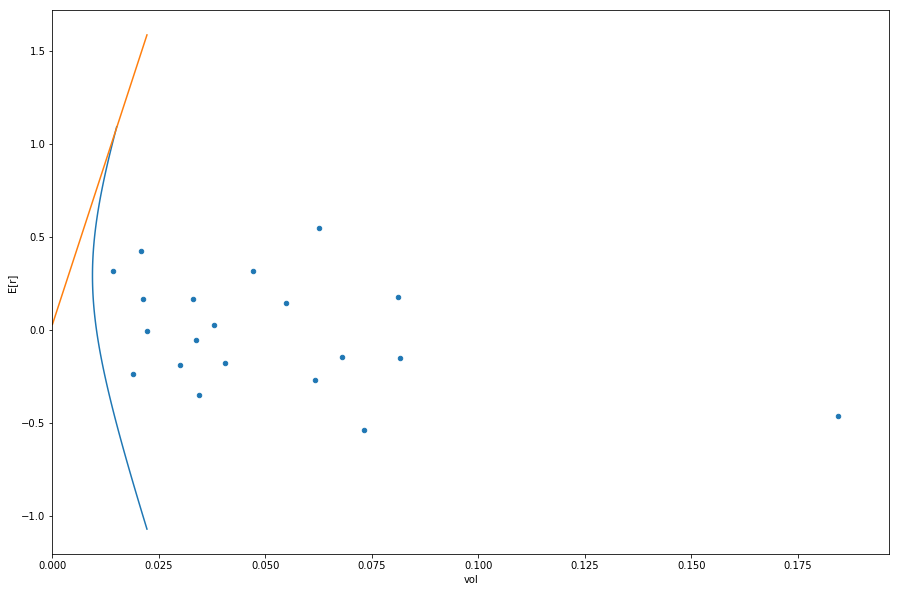

In [44]:
return_sd.plot.scatter(x='vol', y='E[r]')
MVP2, market_port2 = plot_eff_front(np.array(return_sd['E[r]']), np.array(cov_mat), return_sd.index)

Unlevered Minimum Variance Portfolio


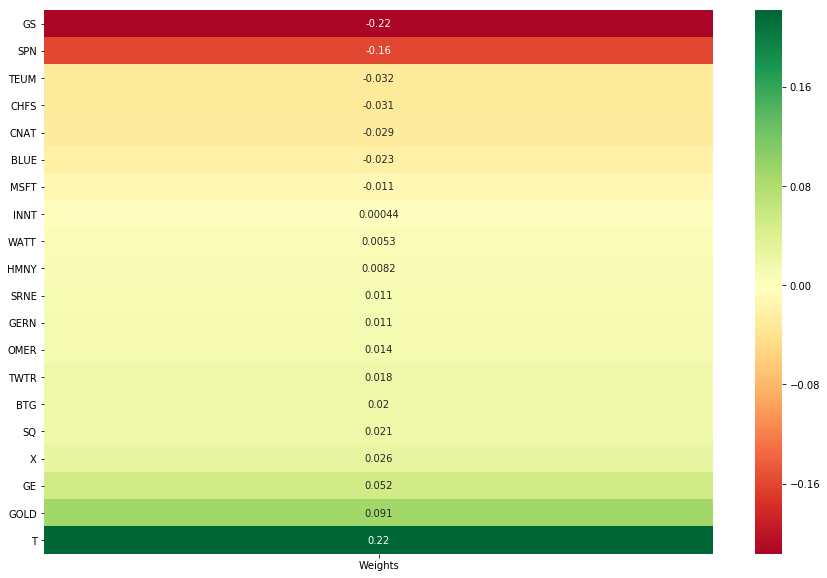

In [45]:
unlevered_MVP2 = unlever_portfolio(MVP2)
print("Unlevered Minimum Variance Portfolio")
sns.heatmap(pd.DataFrame(unlevered_MVP2, columns=['Weights']).sort_values('Weights'), annot=True, cmap='RdYlGn', center=0)

Unlevered Market Portfolio


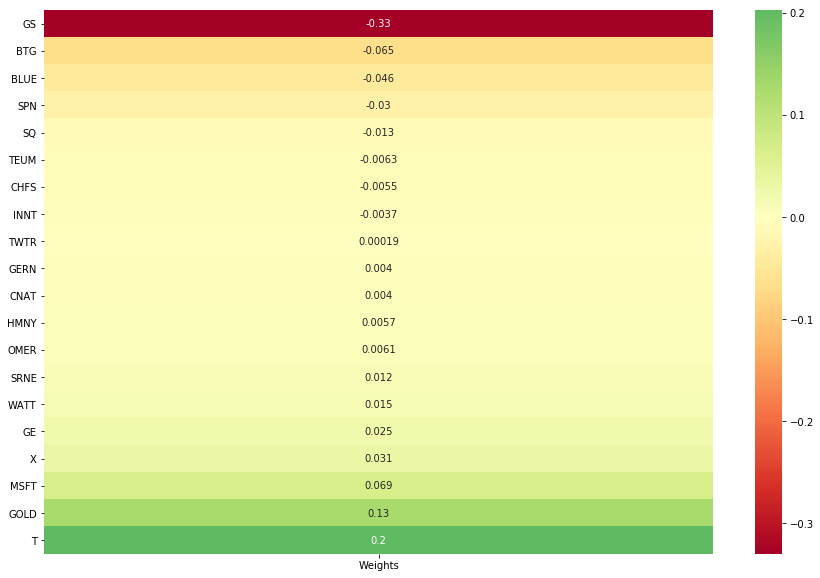

In [46]:
unlevered_market_port2 = unlever_portfolio(market_port2)
print("Unlevered Market Portfolio")
sns.heatmap(pd.DataFrame(unlevered_market_port2, columns=['Weights']).sort_values('Weights'), annot=True, cmap='RdYlGn', center=0)